# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [2]:
data = pd.read_csv('df_rio_interpolado.csv')

In [3]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [4]:
scaler = MinMaxScaler()

In [5]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [6]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [10]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [11]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [12]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [13]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


## Ajuste dos dados para os modelos LSTM e CNN

In [14]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


In [15]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30 
# X_train_series, Y_train_series = create_sequences(scaled_data, seq_length)
# print('Train set shape', X_trains_series.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

# Funções de Métricas Utilizadas e Plot dos Resultados

In [16]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [18]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    return mae, mse, rmse, mape

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [20]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [21]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [22]:
#history_mlp = model_mlp.fit(X_train, Y_train, 
#                            validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp = model_mlp.fit(X_train, 
                            Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            batch_size=batch_mlp, 
                            verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0746 - val_loss: 0.0392
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0377 - val_loss: 0.0331
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0241 - val_loss: 0.0289
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - val_loss: 0.0227
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - val_loss: 0.0212
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170 - val_loss: 0.0193
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - val_loss: 0.0177
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0128
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - val_

### Implementacao e Ajuste do Modelo MLP com regularização

In [23]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [24]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
#                           validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train, 
                                    Y_train, 
                                    validation_data=(X_valid, Y_valid), 
                                    epochs=epochs_mlp, 
                                    batch_size=batch_mlp, 
                                    verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2238 - val_loss: 1.0458
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9819 - val_loss: 0.9187
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9009 - val_loss: 0.8535
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8312 - val_loss: 0.7802
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7653 - val_loss: 0.7218
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7051 - val_loss: 0.6634
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6488 - val_loss: 0.6108
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5974 - val_loss: 0.5624
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5502 - val_loss: 0.5178
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.5068 - val_loss: 0.4771
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4672 - val_loss: 0.4398
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4310 - val

### Implementacao e ajuste do modelo MLP com Dropout

In [25]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))  
model_mlp_drop.add(Dense(32, activation='relu'))
model_mlp_drop.add(Dropout(0.3))  
model_mlp_drop.add(Dense(1))  
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [26]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
#                            validation_data=(X_valid, Y_valid), 
#                            epochs=epochs_mlp, 
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train, 
                                        Y_train, 
                                        validation_data=(X_valid, Y_valid), 
                                        epochs=epochs_mlp, 
                                        batch_size=batch_mlp, 
                                        verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 1.0275 - val_loss: 0.0868
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2581 - val_loss: 0.0463
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1580 - val_loss: 0.0438
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1064 - val_loss: 0.0230
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0802 - val_loss: 0.0228
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0860 - val_loss: 0.0270
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0769 - val_loss: 0.0192
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0725 - val_loss: 0.0232
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0570 - val_loss: 0.0238
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0555 - val_loss: 0.0167
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0481 - val_loss: 0.0188
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0505 - val_l

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [27]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [28]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=batch_mlp, 
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3169 - mae: 0.3124 - val_loss: 0.1782 - val_mae: 0.1228
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2237 - mae: 0.2121 - val_loss: 0.1717 - val_mae: 0.1297
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1877 - mae: 0.1665 - val_loss: 0.1627 - val_mae: 0.1238
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1692 - mae: 0.1435 - val_loss: 0.1525 - val_mae: 0.1129
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1562 - mae: 0.1307 - val_loss: 0.1443 - val_mae: 0.1102
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1513 - mae: 0.1372 - val_loss: 0.1339 - val_mae: 0.0988
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1435 - mae: 0.1254 - val_loss: 0.1313 - val_mae: 0.1077
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1409 - mae: 0.1324 - val_loss: 0.1257 - val_mae: 0.1045
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1334 - mae

## Comparando os 4 modelos

In [29]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Modelo Padrão:
MAE: 0.0917
MSE: 0.0125
RMSE: 0.1116
MAPE: 22.5230%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Modelo com Regularização:
MAE: 0.0730
MSE: 0.0084
RMSE: 0.0917
MAPE: 17.6272%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015EB0430AE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━

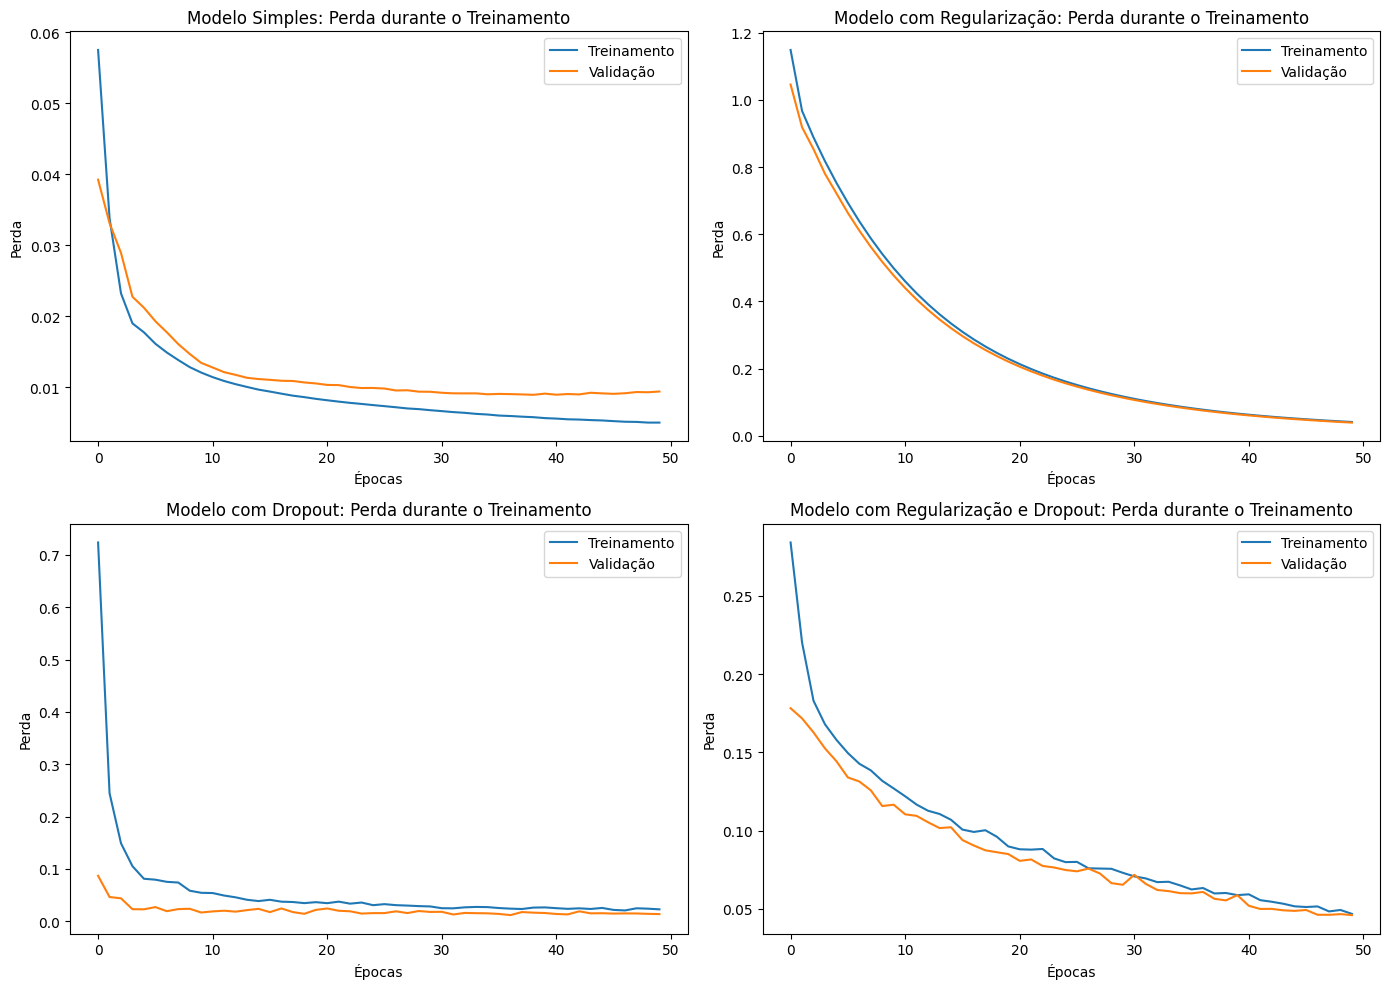

In [30]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


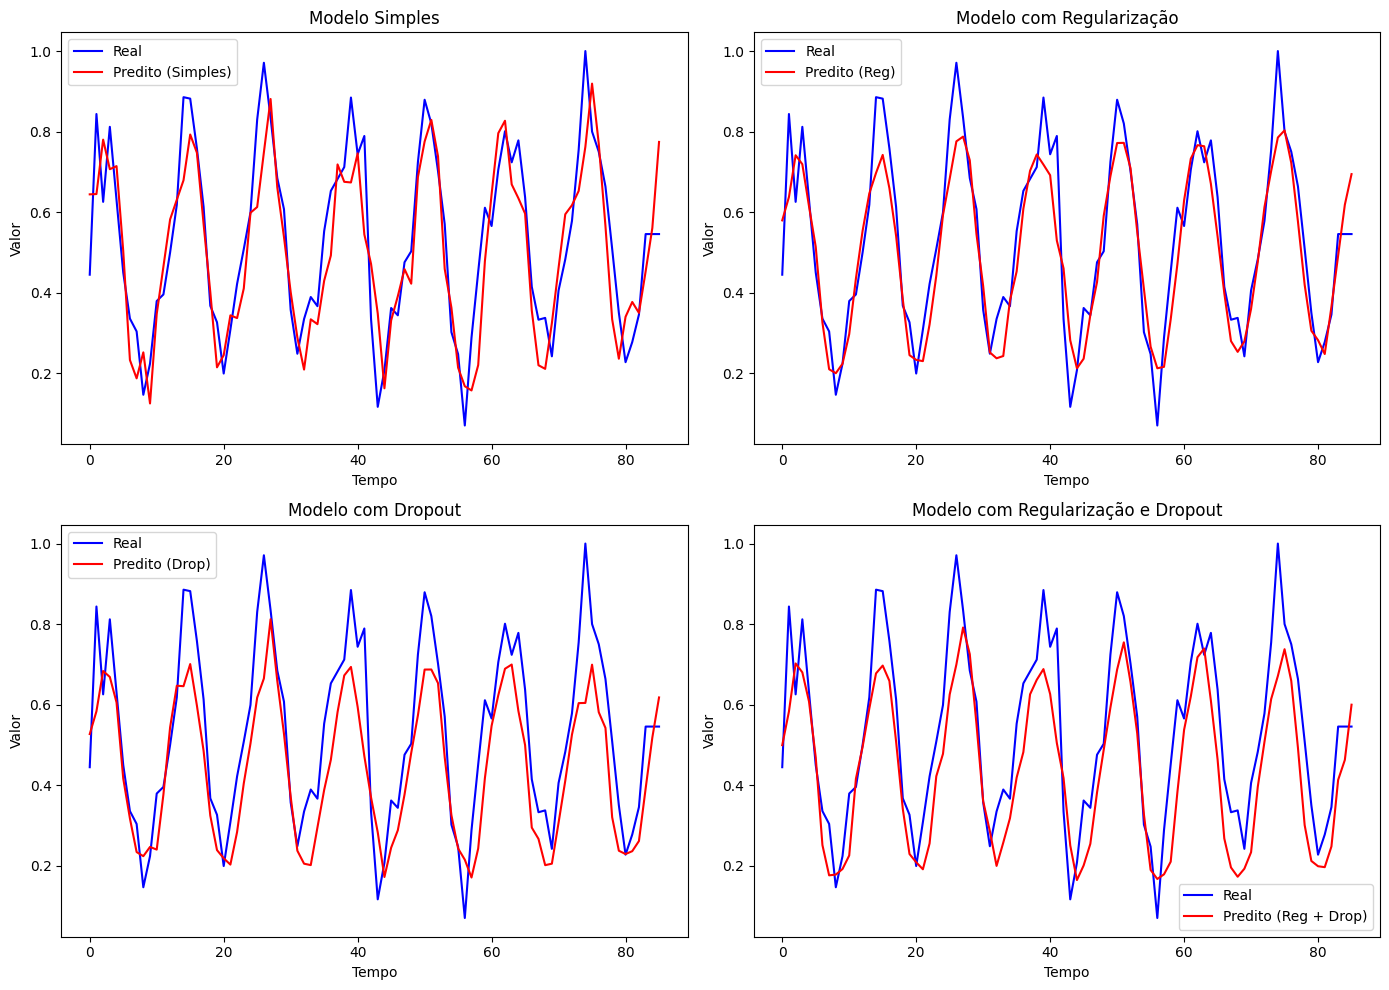

In [32]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_mlp_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

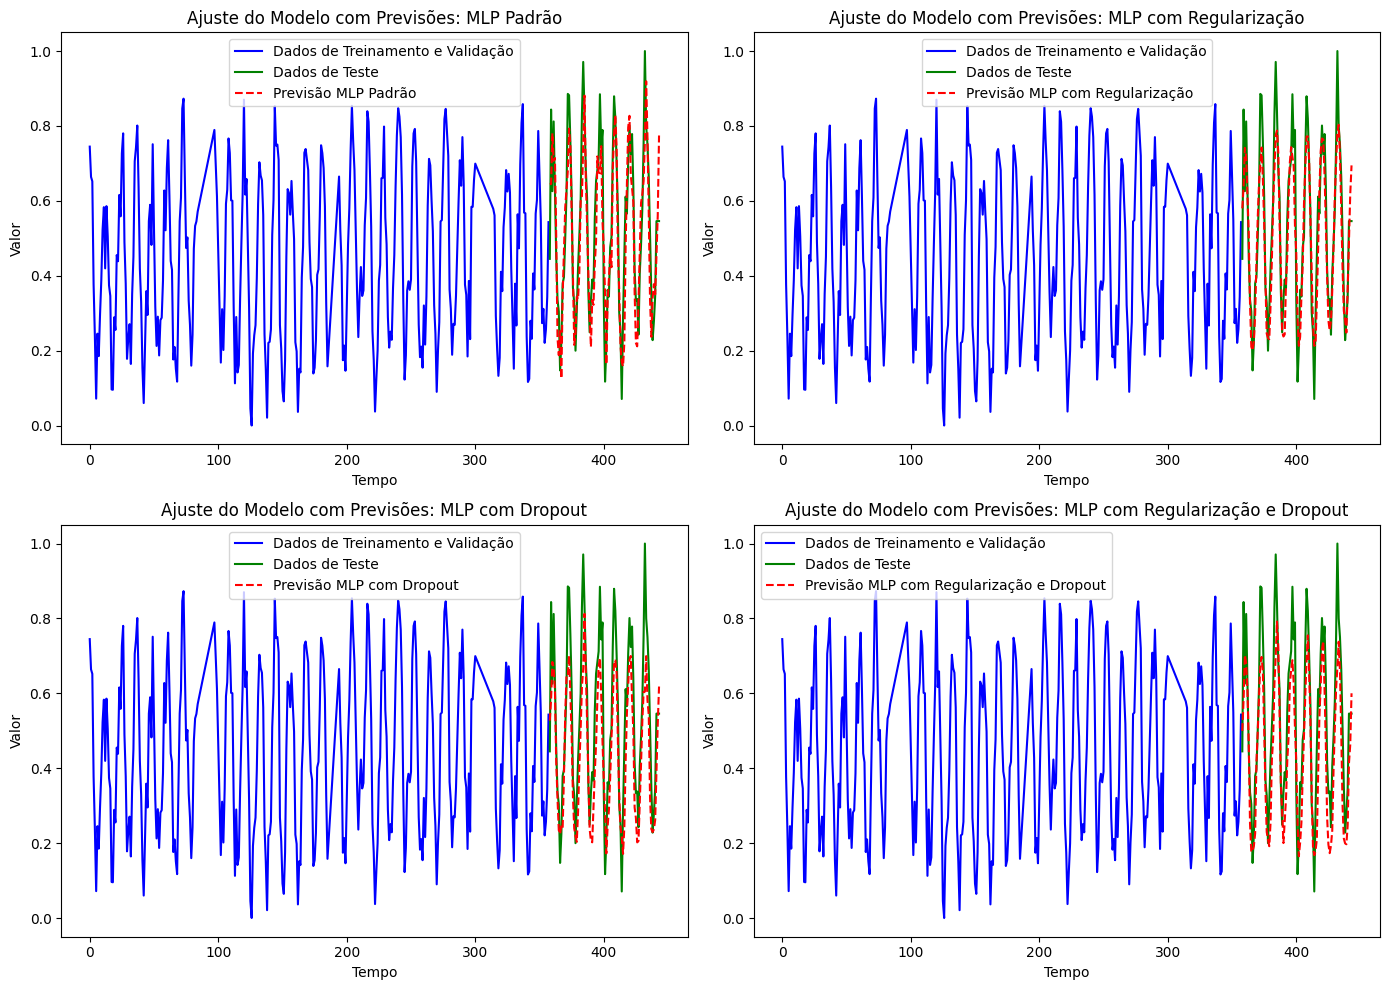

In [33]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [34]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [35]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [36]:
#history_cnn = model_cnn.fit(X_train_series, Y_train, 
#                            validation_data=(X_valid_series, Y_valid), 
#                            epochs=epochs_cnn, 
#                            verbose=2)

history_cnn = model_cnn.fit(X_train, 
                            Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_cnn, 
                            batch_size=batch_cnn, 
                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0759 - val_loss: 0.0131
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - val_loss: 0.0092
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0160 - val_loss: 0.0096
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - val_loss: 0.0106
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140 - val_loss: 0.0093
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0083
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - val_loss: 0.0078
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0072
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0070
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0068
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - val

## Implementando e Ajustando Modelo CNN com Regularização L2

In [37]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [38]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train, 
#                            validation_data=(X_valid_series, Y_valid), 
#                            epochs=epochs_cnn, 
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series, 
                                    Y_train, 
                                    validation_data=(X_valid_series, Y_valid), 
                                    epochs=epochs_cnn, 
                                    batch_size=batch_cnn, 
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.0169 - val_loss: 0.6728
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6004 - val_loss: 0.4129
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3668 - val_loss: 0.2495
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2287 - val_loss: 0.1619
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1517 - val_loss: 0.1151
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1095 - val_loss: 0.0876
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0853 - val_loss: 0.0702
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0700 - val_loss: 0.0587
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596 - val_loss: 0.0500
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - val_loss: 0.0439
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0465 - val_loss: 0.0393
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 - val_l

## Implementando e Ajustando Modelo CNN com Dropout

In [39]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))  
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_drop.summary()

In [40]:
#history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train, 
#                                       validation_data=(X_valid_series, Y_valid), 
#                                       epochs=epochs_cnn, 
#                                       verbose=2)

history_cnn_drop = model_cnn_drop.fit(X_train_series, 
                                    Y_train, 
                                    validation_data=(X_valid_series, Y_valid), 
                                    epochs=epochs_cnn, 
                                    batch_size=batch_cnn, 
                                    verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1338 - val_loss: 0.0521
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0410 - val_loss: 0.0149
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.0111
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0257 - val_loss: 0.0119
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 - val_loss: 0.0114
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0253 - val_loss: 0.0117
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0240 - val_loss: 0.0099
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - val_loss: 0.0092
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - val_loss: 0.0098
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - val_loss: 0.0104
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0221 - val_loss: 0.0086
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - v

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [41]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr))
# model_cnn_reg_drop.summary()

In [42]:
#history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train, 
#                                             validation_data=(X_valid_series, Y_valid), 
#                                             epochs=epochs_cnn, 
#                                             verbose=2)

history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, 
                                            Y_train, 
                                            validation_data=(X_valid_series, Y_valid), 
                                            epochs=epochs_cnn, 
                                            batch_size=batch_cnn, 
                                            verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.1108 - val_loss: 0.7395
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6744 - val_loss: 0.4832
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4583 - val_loss: 0.3348
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3250 - val_loss: 0.2466
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2438 - val_loss: 0.1917
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1976 - val_loss: 0.1561
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1625 - val_loss: 0.1324
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1364 - val_loss: 0.1128
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1201 - val_loss: 0.0976
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1054 - val_loss: 0.0853
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0939 - val_loss: 0.0756
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0830 

## Comparando os 4 Modelos CNN

In [43]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [44]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo Padrão:
MAE: 0.0789
MSE: 0.0096
RMSE: 0.0978
MAPE: 19.8569%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização:
MAE: 0.0791
MSE: 0.0099
RMSE: 0.0993
MAPE: 18.4621%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.0785
MSE: 0.0093
RMSE: 0.0965
MAPE: 20.4537%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0707
MSE: 0.0077
RMSE: 0.0876
MAPE: 19.0585%


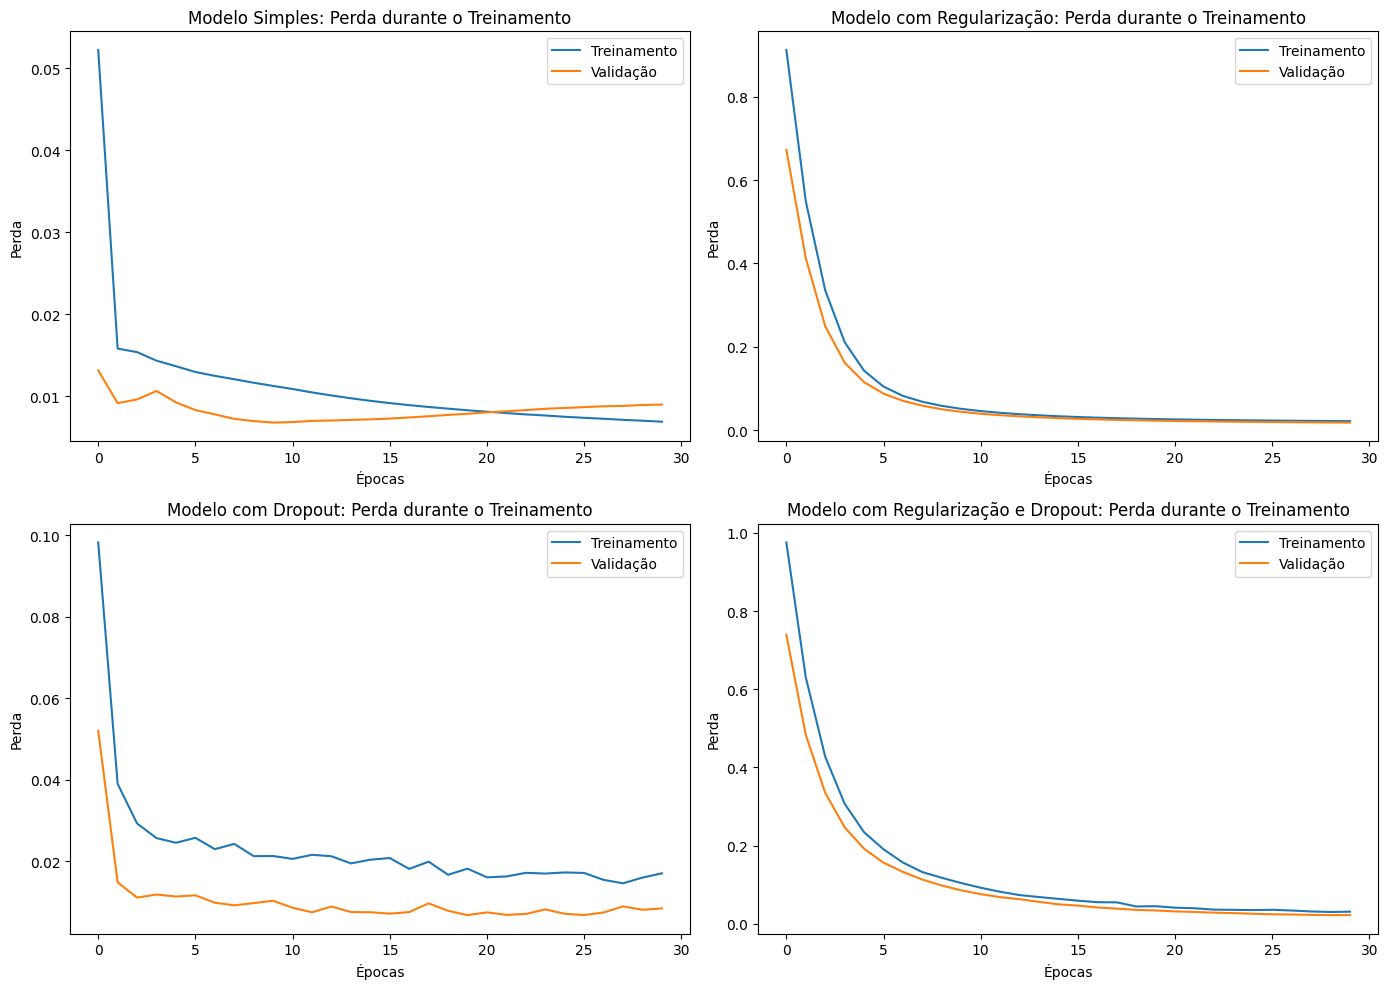

In [45]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


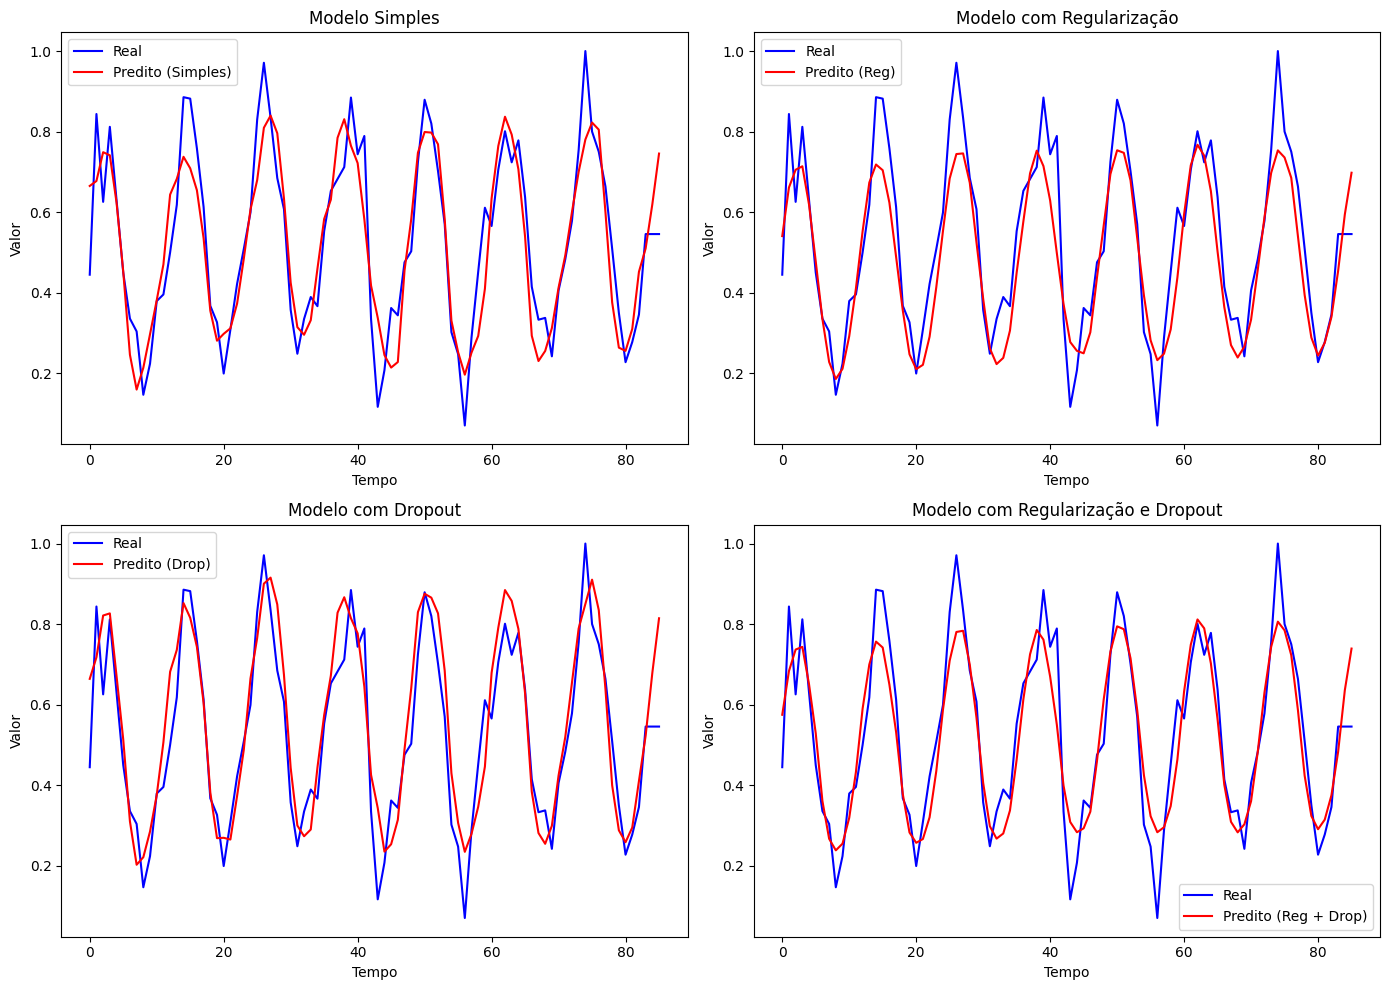

In [46]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


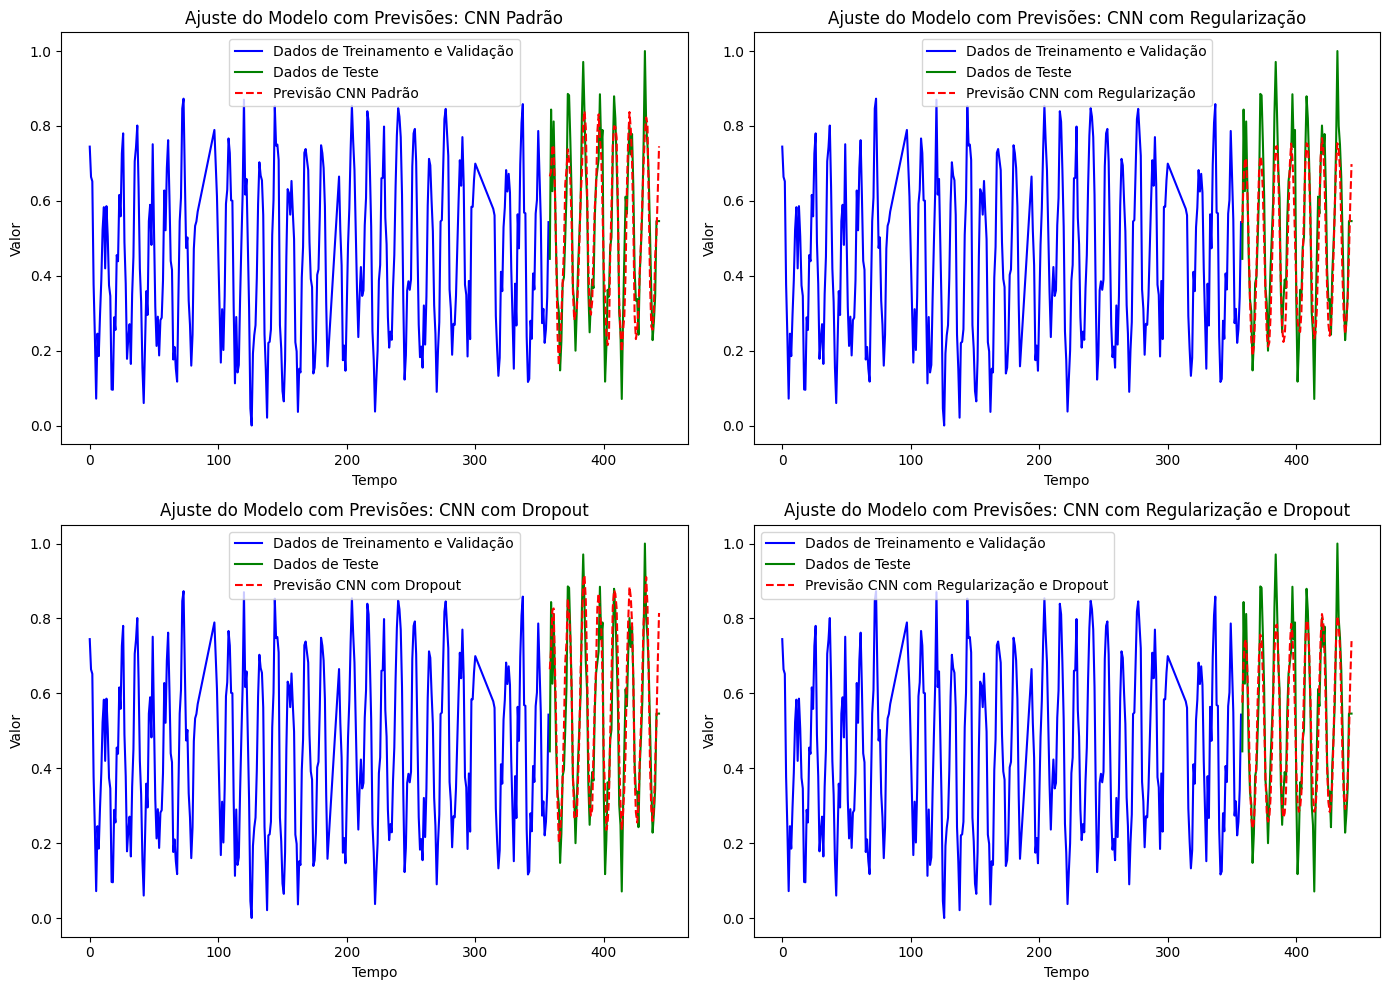

In [47]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [48]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001

## Implementacao e Ajuste do Modelo LSTM

In [49]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [50]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.1918 - val_loss: 0.1241
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0984 - val_loss: 0.0502
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0497 - val_loss: 0.0485
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0455 - val_loss: 0.0479
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0430 - val_loss: 0.0471
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0424 - val_loss: 0.0458
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0413 - val_loss: 0.0448
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0403 - val_loss: 0.0437
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0393 - val_loss: 0.0425
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0382 - val_loss: 0.0412
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0369 - val_loss: 0.0397
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [51]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [52]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series, 
#                                       y_train, 
#                                       epochs=epochs_lstm, 
#                                       batch_size=32, 
#                                       validation_split= 0.15, 
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2801 - val_loss: 0.1867
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1566 - val_loss: 0.0650
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0638 - val_loss: 0.0611
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0591 - val_loss: 0.0600
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0553 - val_loss: 0.0580
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0537 - val_loss: 0.0557
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0518 - val_loss: 0.0545
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0504 - val_loss: 0.0534
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0494 - val_loss: 0.0524
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0484 - val_loss: 0.0516
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0476 - val_loss: 0.0509
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [53]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [54]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series, 
                                              Y_train, 
                                              epochs=epochs_lstm, 
                                              batch_size=batch_lstm, 
                                              validation_data=(X_valid, Y_valid), 
                                              verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1692 - val_loss: 0.0837
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0674 - val_loss: 0.0551
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0557 - val_loss: 0.0516
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0522 - val_loss: 0.0489
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0539 - val_loss: 0.0484
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0494 - val_loss: 0.0490
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0500 - val_loss: 0.0481
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0488 - val_loss: 0.0473
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0479 - val_loss: 0.0467
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0477 - val_loss: 0.0465
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0433 - val_loss: 0.0456
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [55]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3)) 
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [56]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series, 
                            Y_train, 
                            epochs=epochs_lstm,
                            batch_size=batch_lstm, 
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series, 
#                                               Y_train, 
#                                               epochs=epochs_lstm, 
#                                               batch_size=32, 
#                                               validation_data=(X_valid_series, Y_valid), 
#                                               verbose=1)

Epoch 1/50
11/11 - 4s - 406ms/step - loss: 0.2071 - val_loss: 0.1479
Epoch 2/50
11/11 - 0s - 28ms/step - loss: 0.1071 - val_loss: 0.0650
Epoch 3/50
11/11 - 0s - 26ms/step - loss: 0.0701 - val_loss: 0.0617
Epoch 4/50
11/11 - 0s - 27ms/step - loss: 0.0641 - val_loss: 0.0584
Epoch 5/50
11/11 - 0s - 29ms/step - loss: 0.0604 - val_loss: 0.0567
Epoch 6/50
11/11 - 0s - 28ms/step - loss: 0.0579 - val_loss: 0.0554
Epoch 7/50
11/11 - 0s - 26ms/step - loss: 0.0570 - val_loss: 0.0541
Epoch 8/50
11/11 - 0s - 32ms/step - loss: 0.0536 - val_loss: 0.0530
Epoch 9/50
11/11 - 0s - 38ms/step - loss: 0.0563 - val_loss: 0.0522
Epoch 10/50
11/11 - 1s - 57ms/step - loss: 0.0543 - val_loss: 0.0513
Epoch 11/50
11/11 - 0s - 28ms/step - loss: 0.0545 - val_loss: 0.0506
Epoch 12/50
11/11 - 0s - 27ms/step - loss: 0.0543 - val_loss: 0.0500
Epoch 13/50
11/11 - 0s - 27ms/step - loss: 0.0564 - val_loss: 0.0494
Epoch 14/50
11/11 - 0s - 29ms/step - loss: 0.0504 - val_loss: 0.0488
Epoch 15/50
11/11 - 0s - 27ms/step - loss:

## Comparativo entre os modelos - Predicao e Validacao

In [57]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step

Modelo Padrão:
MAE: 0.0872
MSE: 0.0122
RMSE: 0.1104
MAPE: 20.5112%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

Modelo com Regularização:
MAE: 0.0824
MSE: 0.0105
RMSE: 0.1026
MAPE: 18.7464%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Modelo com Dropout:
MAE: 0.0926
MSE: 0.0140
RMSE: 0.1184
MAPE: 21.7035%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Modelo com Regularização e Dropout:
MAE: 0.1031
MSE: 0.0171
RMSE: 0.1307
MAPE: 26.0836%


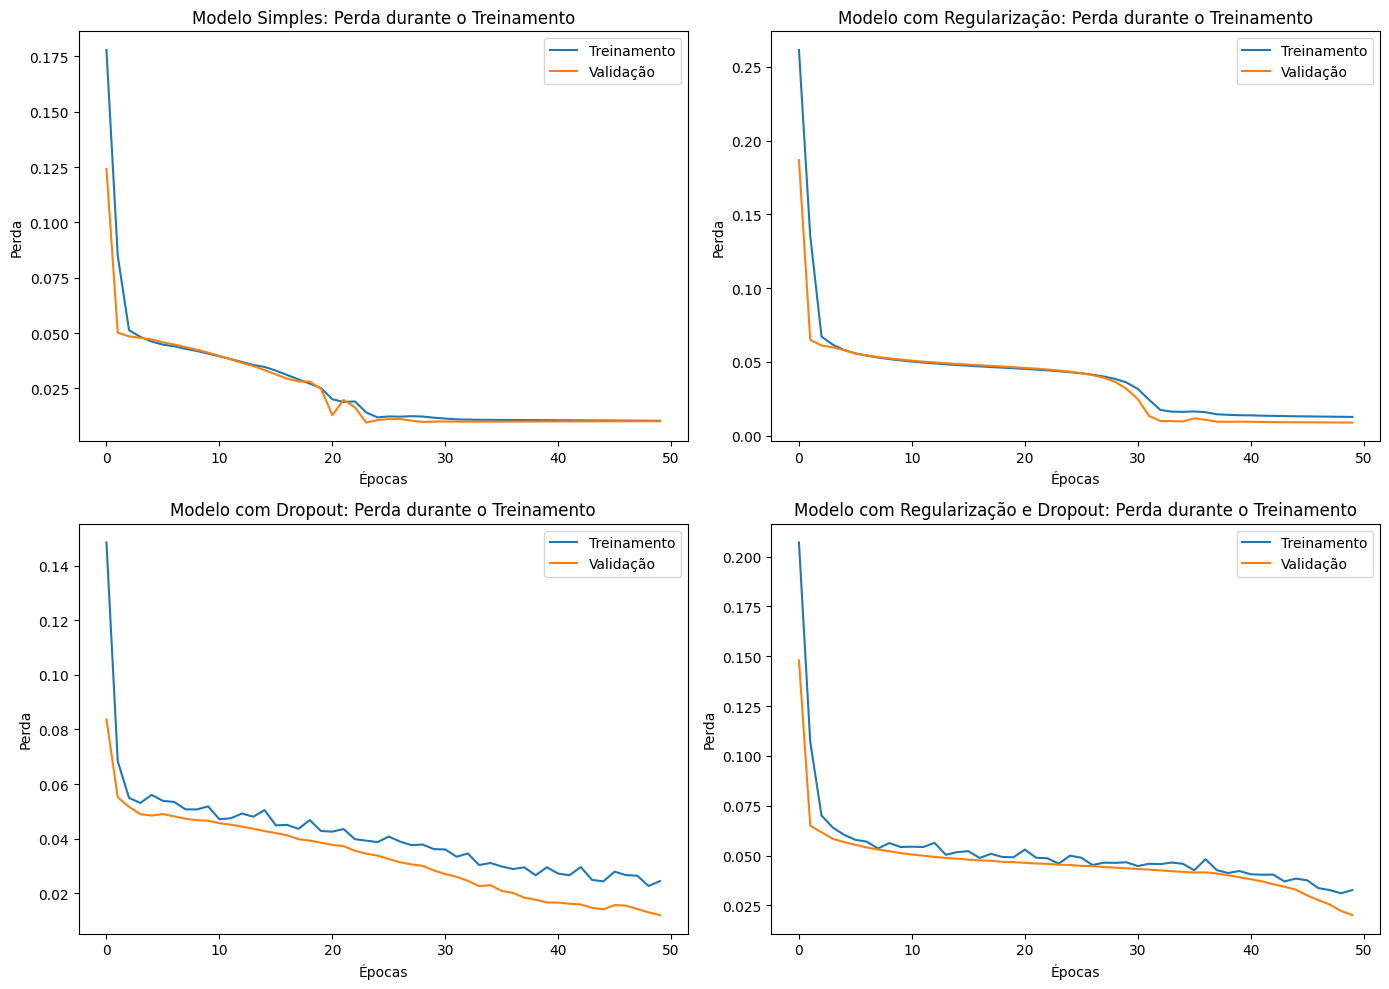

In [58]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_lstm.history['loss'], label='Treinamento')
plt.plot(history_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


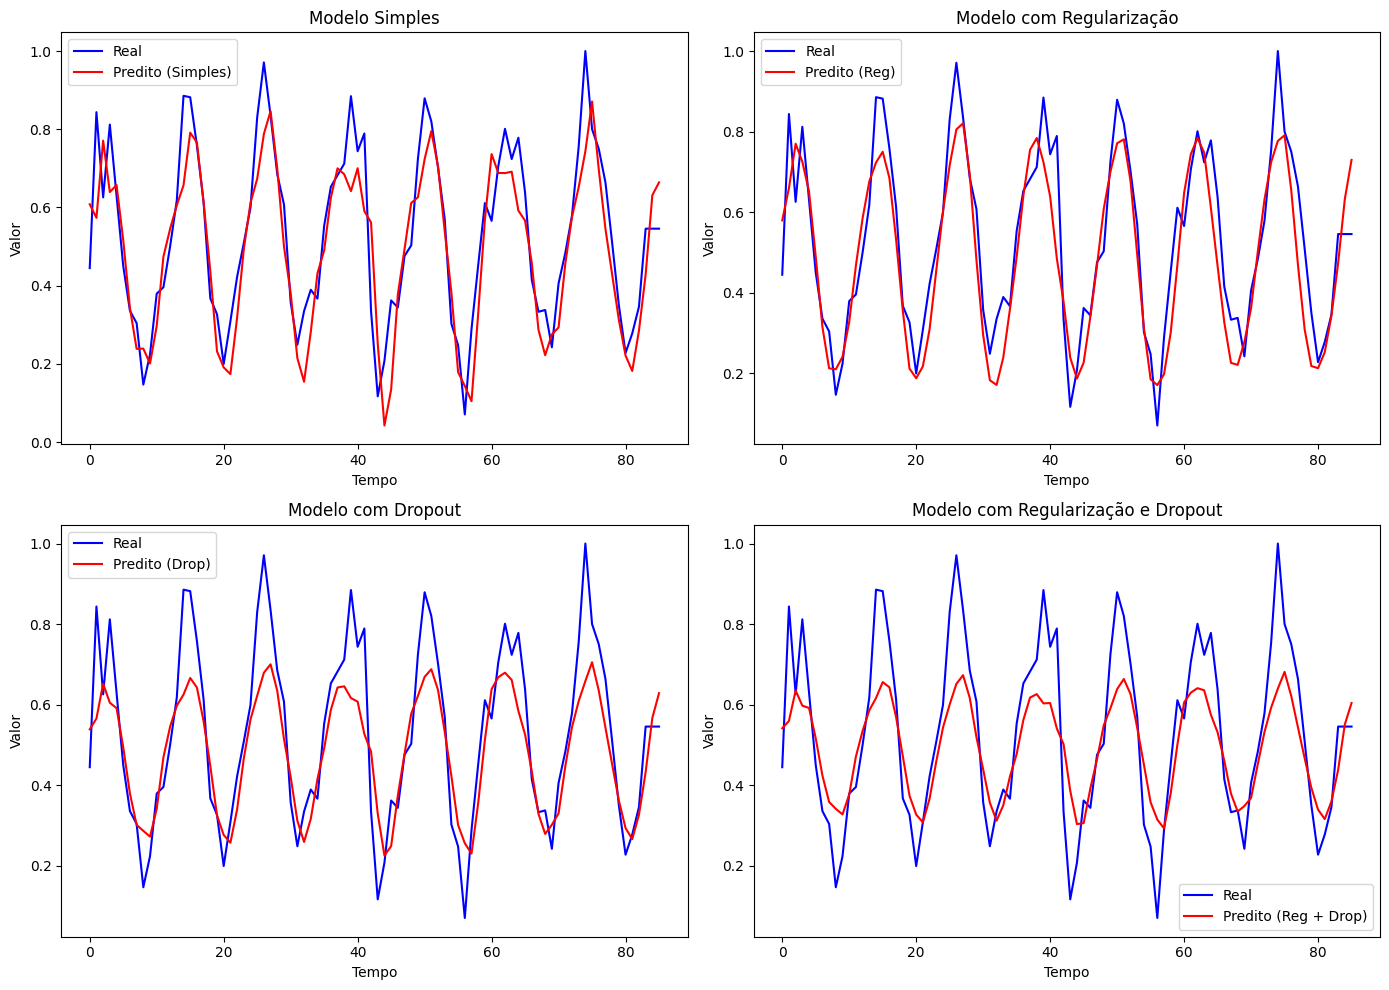

In [60]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


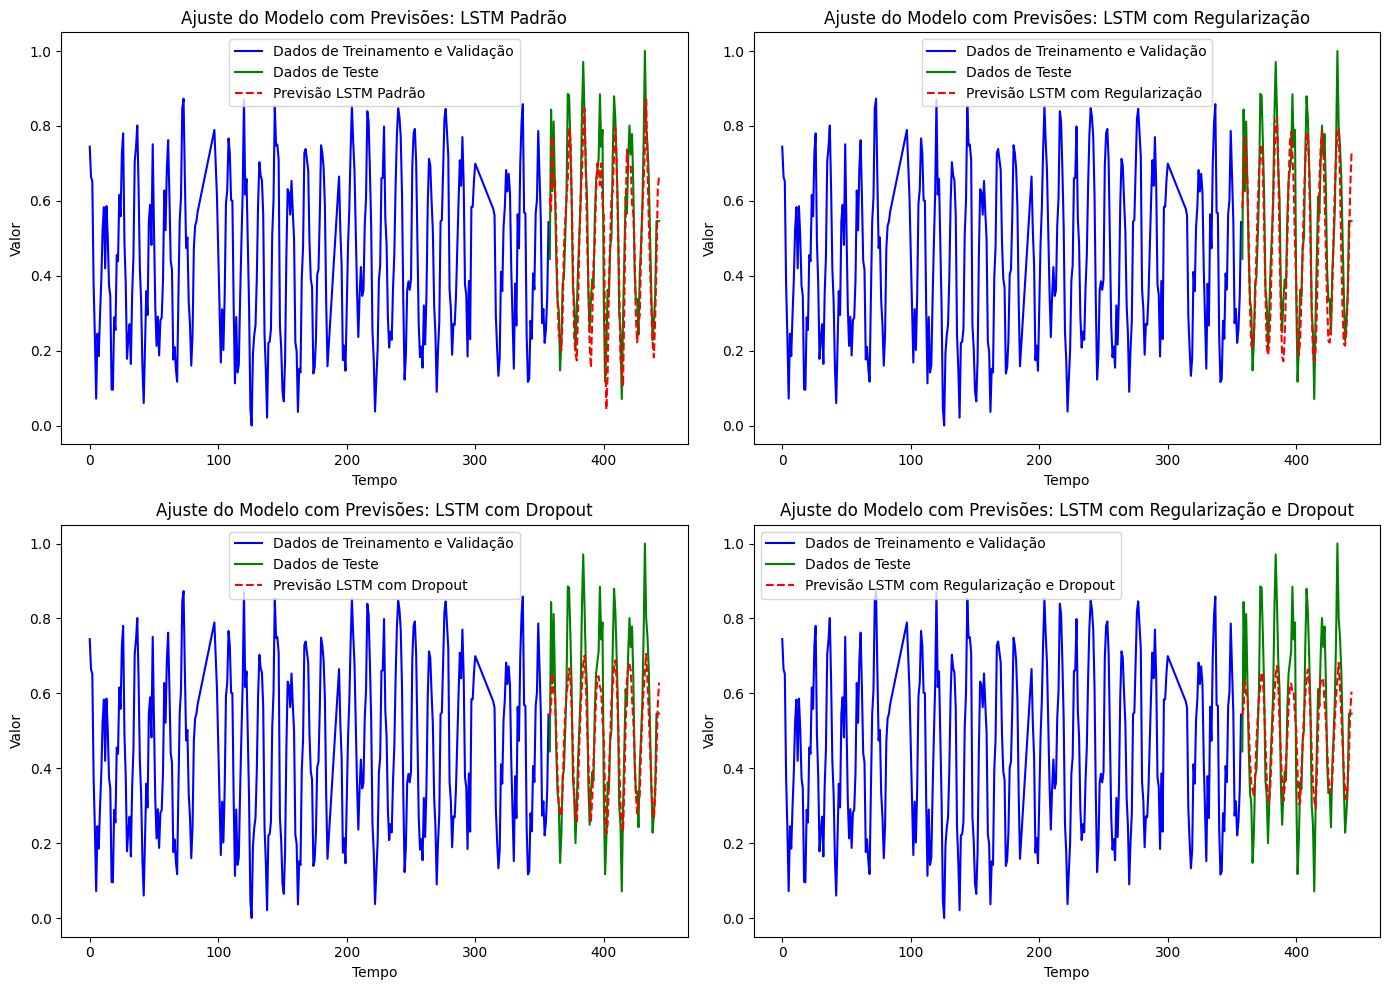

In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [62]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2

In [63]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)
Test set shape (86, 2, 30, 1)


## Implementacao e ajuste do modelo padrao

In [64]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [65]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid, 
                                      verbose=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1426 - val_loss: 0.0661
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0492 - val_loss: 0.0451
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0420 - val_loss: 0.0446
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0378 - val_loss: 0.0330
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0319 - val_loss: 0.0282
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0257 - val_loss: 0.0184
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0123
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0102
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0094
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0130 - val_loss: 0.0094
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

## Implementacao e Ajuste do modelo com Regularizacao

In [66]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [67]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, 
                                              Y_train, 
                                              validation_data=(X_valid_series_sub, Y_valid), 
                                              epochs=epochs_hibrid, 
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.4734 - val_loss: 0.2677
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2360 - val_loss: 0.1598
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1455 - val_loss: 0.1041
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0983 - val_loss: 0.0745
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0726 - val_loss: 0.0562
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0575 - val_loss: 0.0449
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0477 - val_loss: 0.0403
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0428 - val_loss: 0.0365
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0394 - val_loss: 0.0328
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0364 - val_loss: 0.0304
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0340 - val_loss: 0.0286
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo com Dropout

In [68]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [69]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub, 
                                                Y_train, 
                                                validation_data=(X_valid_series_sub, Y_valid), 
                                                epochs=epochs_hibrid, 
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.1366 - val_loss: 0.0505
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0583 - val_loss: 0.0396
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0447 - val_loss: 0.0250
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0374 - val_loss: 0.0189
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0294 - val_loss: 0.0114
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0216 - val_loss: 0.0093
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0198 - val_loss: 0.0092
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0174 - val_loss: 0.0085
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0173 - val_loss: 0.0086
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0185 - val_loss: 0.0093
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0178 - val_loss: 0.0082
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [70]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub, 
                                                        Y_train, 
                                                        validation_data=(X_valid_series_sub, Y_valid), 
                                                        epochs=epochs_hibrid, 
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.4385 - val_loss: 0.2738
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2484 - val_loss: 0.1656
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1564 - val_loss: 0.1027
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1070 - val_loss: 0.0709
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0804 - val_loss: 0.0562
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0640 - val_loss: 0.0472
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0545 - val_loss: 0.0445
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0548 - val_loss: 0.0382
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0461 - val_loss: 0.0353
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0435 - val_loss: 0.0330
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0453 - val_loss: 0.0307
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

## Comparativo entre os modelos

In [77]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [72]:
# # Cálculo das métricas para cada modelo
# metrics = {
#     "Modelo LSTM": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
#     },
#     "Modelo LSTM com Regularização": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
#     },
#     "Modelo LSTM com Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
#     },
#     "Modelo LSTM com Regularização e Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
#     }
# }

# # Exibir as métricas
# for model, values in metrics.items():
#     print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")

In [73]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step

Modelo Padrão:
MAE: 0.0746
MSE: 0.0083
RMSE: 0.0912
MAPE: 18.3707%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step

Modelo com Regularização:
MAE: 0.0799
MSE: 0.0094
RMSE: 0.0969
MAPE: 18.4703%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step

Modelo com Dropout:
MAE: 0.0746
MSE: 0.0087
RMSE: 0.0930
MAPE: 17.9056%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step

Modelo com Regularização e Dropout:
MAE: 0.0704
MSE: 0.0078
RMSE: 0.0881
MAPE: 17.4011%


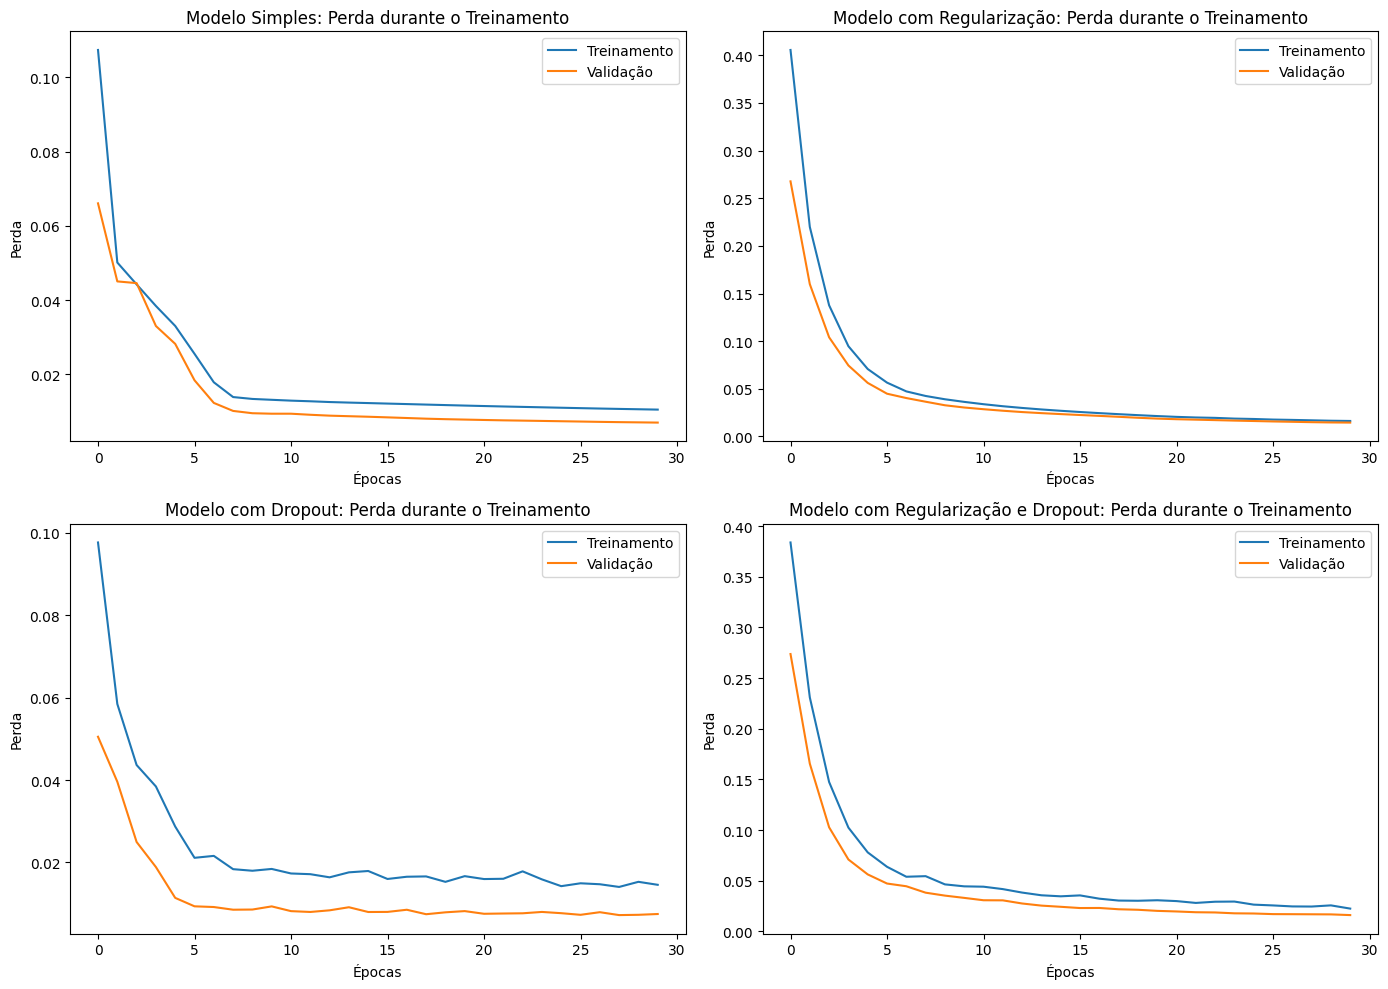

In [74]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_cnn_lstm.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_cnn_lstm_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_cnn_lstm_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_cnn_lstm_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_cnn_lstm_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

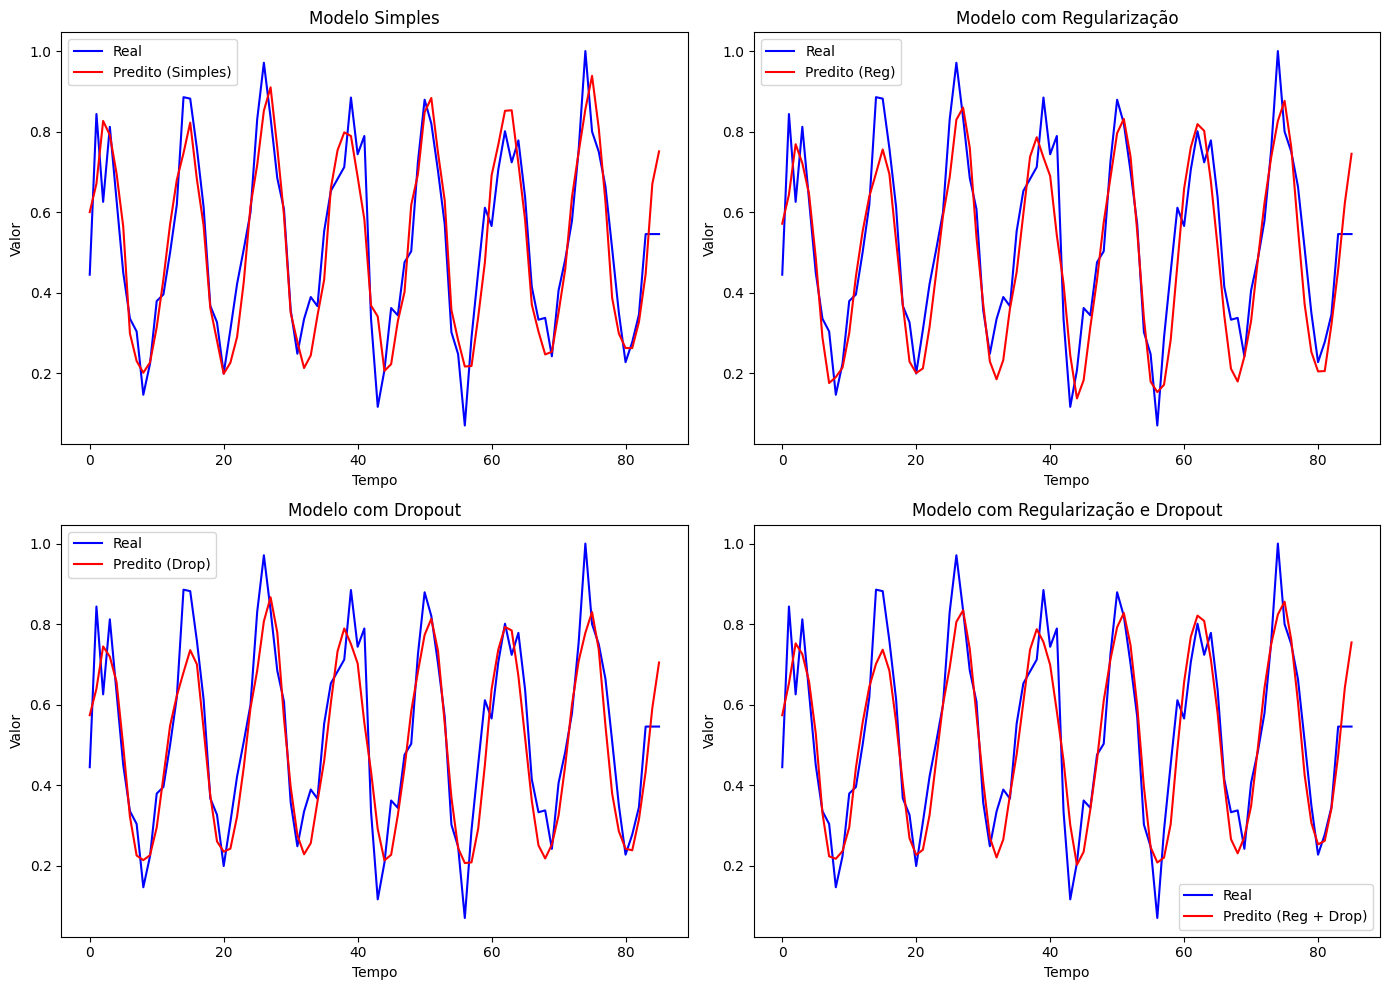

In [79]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(y_pred_cnn_lstm_reg_drop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

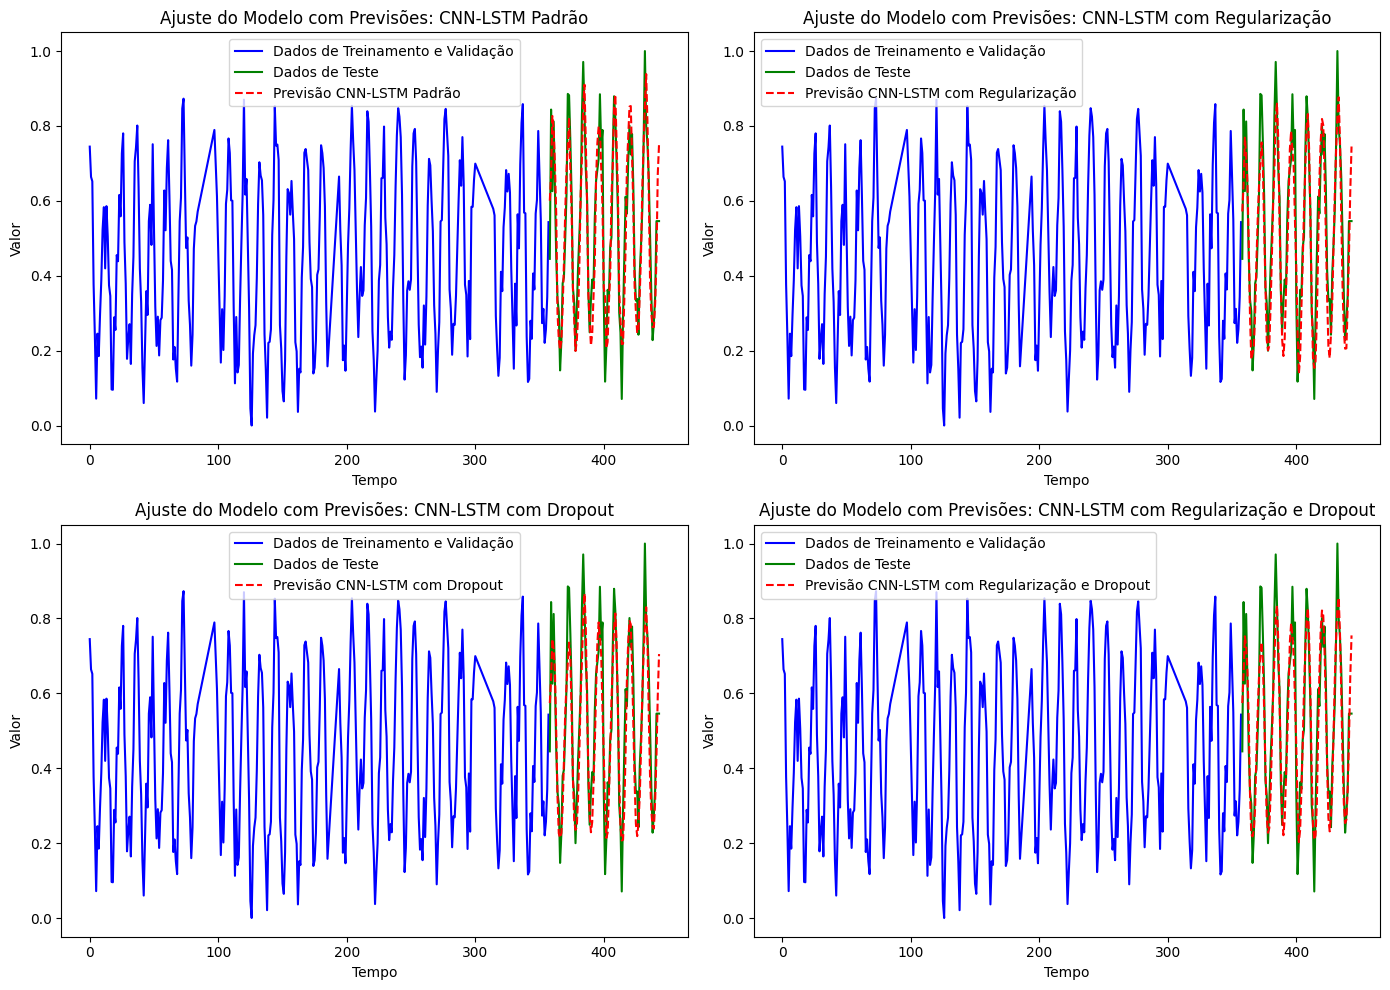

In [78]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)